## Paavo Reinikka, 589479

### Lab exercise #5: 

In [2]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.kernels import White, RBF
from gpflow.likelihoods import Gaussian
from deep_gp import DeepGP
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
import gpflow as gpf

#import seaborn as sns
#import pandas as pd

# Deep Gaussian Processes

-------------------

# Part 1 - Sampling From a Deep GP


In [3]:
np.random.seed(111)
N = 500
x = np.linspace(-20, 20, num=N)

gp_var = 1.0  # GP variance
gp_len = 1.0  # GP lengthscale

def rbf_kernel(x1, x2):
    x1 = x1.reshape(-1, 1, 1)
    x2 = x2.reshape(1, -1, 1)
    r = np.sum(x1 - x2, axis=-1)
    return gp_var * np.exp(-0.5 * np.square(r) / np.square(gp_len))


def zero_mean(X):
    return np.zeros_like(X.reshape(-1, ))


def identity_mean(X):
    return X.reshape(-1, )

**Task 1a**: Generate a sample from a 3-layer deep GP with **zero mean** and an **RBF kernel**. Use the inputs, x, and parameters given above. Plot the sample path and the covariance matrix in each layer.

**Do you notice any strange behaviour in the sample path and/or covariance matrix? Write a short explanation of the behaviour and why you think it may be occuring.**

hint 1: you can use np.random.multivariate_normal() to sample from a Gaussian distribution. ***Note: you may need to add a small value to the diagonal of the covariance matrix to prevent numerical issues during sampling, e.g. + 1e-10 * np.eye(N)***

hint 2: use plt.imshow() to plot a covariance matrix

hint 3: always plot the initial inputs, x, on the x-axis of the sample plots.

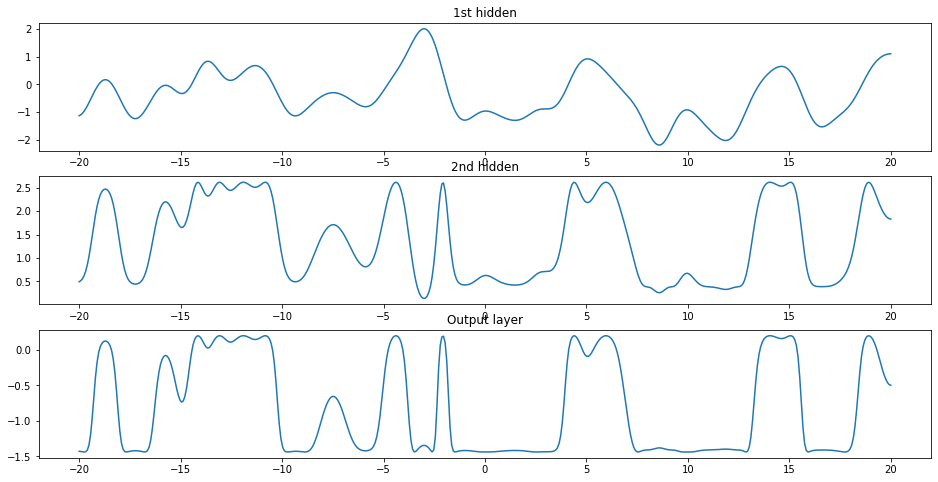

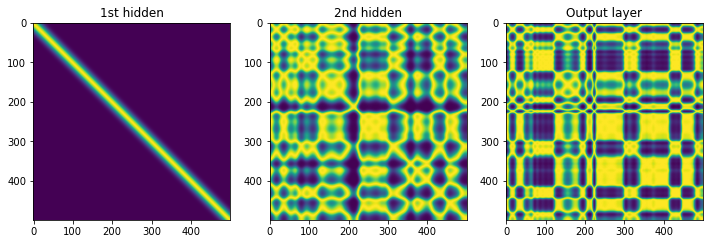

In [4]:
def sample(m, S):
    L=np.linalg.cholesky(S + 1e-12*np.identity(S.shape[0]))
    return m + L @ np.random.normal(0, 1, size=m.shape)

#sns.set_style('darkgrid')

K1 = rbf_kernel(x,x)
h1 = sample(zero_mean(x), K1)
K2 = rbf_kernel(h1,h1)
h2 = sample(zero_mean(h1), K2)
Kout = rbf_kernel(h2,h2)
out = sample(zero_mean(h2), Kout)
plt.figure(figsize=[16,8])
plt.subplot(3,1,1)
plt.plot(x,h1);plt.title('1st hidden')
plt.subplot(3,1,2)
plt.plot(x,h2);plt.title('2nd hidden')
plt.subplot(3,1,3)
plt.plot(x,out);plt.title('Output layer')
plt.show()

plt.figure(figsize=[12,6])
plt.subplot(1,3,1)
plt.imshow(K1,cmap='viridis');plt.title('1st hidden')
plt.subplot(1,3,2)
plt.imshow(K2,cmap='viridis');plt.title('2nd hidden')
plt.subplot(1,3,3)
plt.imshow(Kout,cmap='viridis');plt.title('Output layer')
plt.show()


**Here are the layer activations on the same axis:**

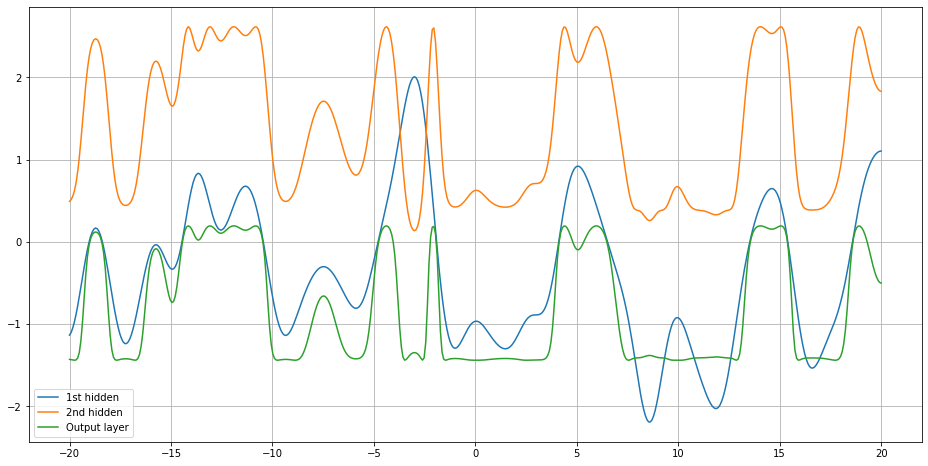

In [5]:
plt.figure(figsize=[16,8])
plt.plot(x,h1)
plt.plot(x,h2)
plt.plot(x,out)
plt.legend(['1st hidden','2nd hidden','Output layer'])
plt.grid()
plt.show()

**Comments:**

**The first activation (h1) is an uninteresting standard Gaussian process (inputs are just a deterministic sample from the real line) - the kernel image shows the familiar diagonal, implying little correlation, and only locally (as expected with gp_len=1).**

**The second activation (h2) is showinf interesting correlations over long distances (non-locally): Inspecting any horizontal/vertical line on the kernel image reveals rich structure. Looking at the sample path, it looks like the second covariance is capturing the disturbances in the inputs (h1), and strengthening them (correlating points in close proximity). Most notably, and unlike h1, h2 is not a stationary process.**

**The output layer is magnifying the correlations, and overall the structure of the covariance matrix. Process is non-stationary, and seems to be operating on multiple different lengthscales (with respect to the inputs).** 

**Task 1b**: Now generate a sample from a 3-layer deep GP, now with the **identity mean function for the first two layers**, and a **zero mean function for the final layer**. Plot the samples from each layer and the covariance matrices.

**Do you notice any differences in the behaviour between this sample and the previous one? Write a short explanation.**

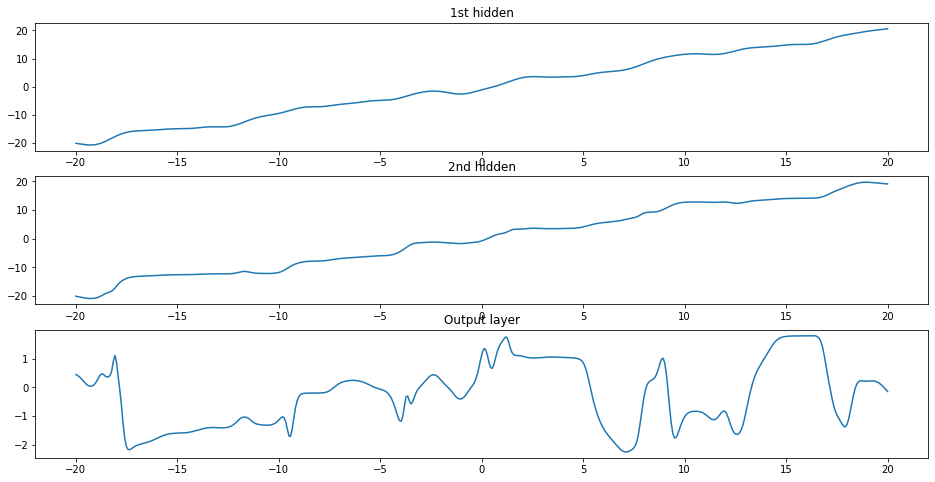

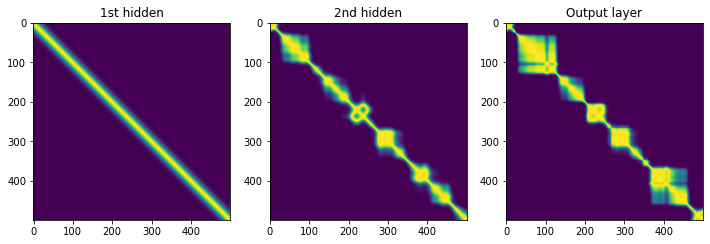

In [6]:
K1 = rbf_kernel(x,x)
h1 = sample(identity_mean(x), K1)
K2 = rbf_kernel(h1,h1)
h2 = sample(identity_mean(h1), K2)
Kout = rbf_kernel(h2,h2)
out = sample(zero_mean(h2), Kout)
plt.figure(figsize=[16,8])
plt.subplot(3,1,1)
plt.plot(x,h1);plt.title('1st hidden')
plt.subplot(3,1,2)
plt.plot(x,h2);plt.title('2nd hidden')
plt.subplot(3,1,3)
plt.plot(x,out);plt.title('Output layer')
plt.show()

plt.figure(figsize=[12,6])
plt.subplot(1,3,1)
plt.imshow(K1,cmap='viridis');plt.title('1st hidden')
plt.subplot(1,3,2)
plt.imshow(K2,cmap='viridis');plt.title('2nd hidden')
plt.subplot(1,3,3)
plt.imshow(Kout,cmap='viridis');plt.title('Output layer')
plt.show()

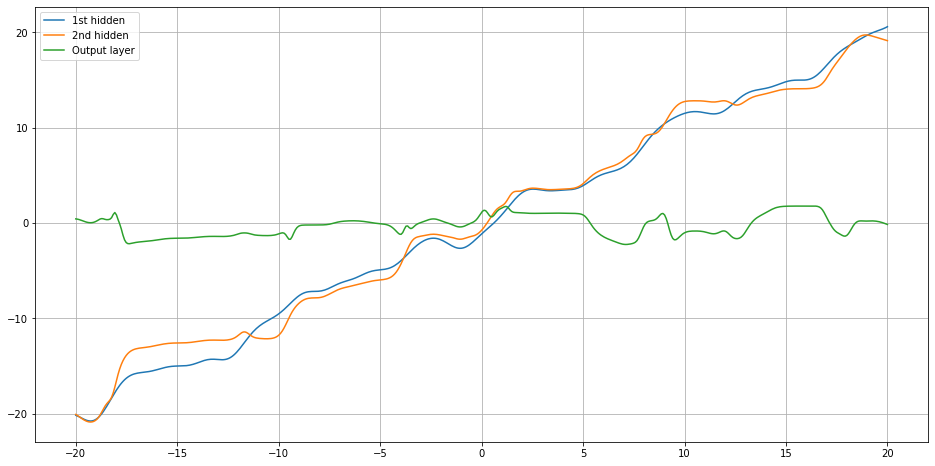

In [6]:
plt.figure(figsize=[16,8])
plt.plot(x,h1)
plt.plot(x,h2)
plt.plot(x,out)
plt.legend(['1st hidden','2nd hidden','Output layer'])
plt.grid()
plt.show()

**Comments:**

**Since the 1st hidden layer propagates the inputs through an identity mapping, the activation (h1) adds a trend atop randomness - first kernel is naturally the same as before (nothing has changed for it).**

**The trend dominates the second hidden layer's covariance matrix, since the random fluctuations are comparatively small. The 2nd layer also picks up some correlations from the fluctuations, and the kernel shows some emerging structure (non-stationarity). The sample path is seemingly not very different from the previous one, and...**

**... the output layer magnifies the non-stationarity. Output process is zero mean, and the identity mappings within the hidden layers have effectively thresholded all the random fluctuations in the h1 and h2 from filling it with "noise" - i.e., the identity mappings (and the resulting trendline) made the smaller perturbations insignificant, and only some structure was propagated to outputs.**


-----------------------

# Part 2 - Training a Deep GP

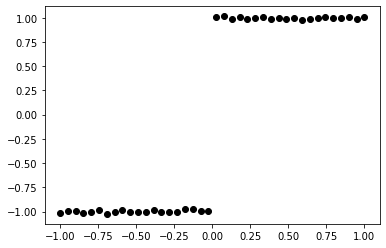

In [7]:
tf.random.set_seed(0)
np.random.seed(123)
N = 40
X_train = np.linspace(-1, 1, N)[:, None]
f_step = lambda x: -1 if x < 0 else 1.
Y_train = np.reshape([f_step(x) for x in X_train], X_train.shape) + np.random.randn(*X_train.shape) * 1e-2
Xs = np.linspace(-2., 2, 300)[:, None]  # test inputs
plt.scatter(X_train, Y_train, color='k');

**Task 2a:** The ELBO calculation has been removed from the deep GP implementation. 

In [ ]:
class MyDeepGP(DeepGP):

    def elbo(self, data):
        """
        :param data: Tuple of two tensors for input data X and labels Y.
        :return: Tensor representing ELBO.
        """
        X, Y = data  # mini-batch data for the current training step
        N_star = X.shape[0]  # number of points in the mini-batch
        N = self.num_data  # total number of data points
        S = self.num_samples  # the number of samples used to evaluate the marginals, q(f_{L,n})
        
        ############################################
        ######### ELBO implementation ##############
        ############################################
                
        # self.predict_f() produces samples from the marginal, q(f_{L,n,s}):
        F_mean, F_var = self.predict_f(X, num_samples=S, full_cov=False)
        
        # now use self.likelihood.variational_expectations(F_mean, F_var, Y) to evaluate following:
        # \int q(f_{L,n,s}) ln p(y_n | f_{L,n,s}) d f_{L,n,s}
        
        # Compute the KL term. The KL for a single layer, i, can be computed as follows:
        # gpflow.kullback_leiblers.gauss_kl(self.layers[i].q_mu, self.layers[i].q_sqrt, K=self.layers[i].Ku)
        likeli_term=tf.reduce_sum(self.likelihood.variational_expectations(F_mean,F_var, Y))#tf.broadcast_to(Y,F_mean.shape)))
        
        kl_term=tf.reduce_sum([gpflow.kullback_leiblers.gauss_kl(self.layers[i].q_mu,\
                               self.layers[i].q_sqrt, K=self.layers[i].Ku) for i in range(len(self.layers))])
        
        ELBO = N*likeli_term/(S*N_star) - kl_term
        
        return ELBO

Now train the model and plot the posterior by running the following code (no modification needed):

iter 100, ELBO: -74.5692
iter 200, ELBO: -64.4513
iter 300, ELBO: -57.7475
iter 400, ELBO: -46.3501
iter 500, ELBO: -22.9253
iter 600, ELBO: 7.7400
iter 700, ELBO: 7.7406
iter 800, ELBO: 16.8546
iter 900, ELBO: 29.4180
iter 1000, ELBO: 37.9485
iter 1100, ELBO: 48.0641
iter 1200, ELBO: 58.4173
iter 1300, ELBO: -17.3859
iter 1400, ELBO: 36.7501
iter 1500, ELBO: 43.5081
iter 1600, ELBO: 45.5606
iter 1700, ELBO: 49.8285
iter 1800, ELBO: 51.2982
iter 1900, ELBO: 50.1933
iter 2000, ELBO: 55.7779
iter 2100, ELBO: -38.5070
iter 2200, ELBO: 53.4634
iter 2300, ELBO: 55.6789
iter 2400, ELBO: 52.3657
iter 2500, ELBO: 56.9382
iter 2600, ELBO: -2.3830
iter 2700, ELBO: 38.0397
iter 2800, ELBO: 50.2581
iter 2900, ELBO: 54.4803
iter 3000, ELBO: 57.2888
iter 3100, ELBO: 55.3568
iter 3200, ELBO: 54.3192
iter 3300, ELBO: 26.7651
iter 3400, ELBO: -1.4072
iter 3500, ELBO: 32.5558
iter 3600, ELBO: 42.0262
iter 3700, ELBO: 44.6003
iter 3800, ELBO: 49.1455
iter 3900, ELBO: 50.0972
iter 4000, ELBO: 53.0314
iter

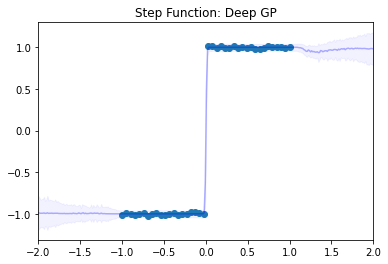

In [9]:
## Helper functions used to build and train the deep GP

def make_deep_GP(num_layers, X, Y, Z):
    kernels = []
    layer_sizes = []
    for l in range(num_layers):
        kernel = RBF(lengthscales=0.2, variance=1.0) + White(variance=1e-4)
        kernels.append(kernel)
        layer_sizes.append(1)

    dgp = MyDeepGP(X, Y, Z, kernels, layer_sizes, Gaussian(variance=1), num_samples=20)

    # init hidden layers to be near deterministic
    for layer in dgp.layers[:-1]:
        layer.q_sqrt.assign(layer.q_sqrt * 1e-2)
    return dgp


@tf.function()
def training_step(model, opt):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = -model.elbo((X_train, Y_train))
        gradients = tape.gradient(obj, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return obj



#OBS:
np.random.seed(0)
## Now train the model and plot the result

M = 20  # num inducing points
num_layers = 3  # number of layers
Z_init = np.random.uniform(-1, 1, M)[:, None]
dgp = make_deep_GP(num_layers, X_train, Y_train, Z_init)
optimizer = tf.optimizers.Adam(learning_rate=0.01, epsilon=1e-08)

num_iters = 5000

for it in range(1, num_iters + 1):
    objective = training_step(dgp, optimizer)
    if np.mod(it, 100) == 0:
        print('iter %2d, ELBO: %1.4f' % (it, -objective.numpy()))

m_test, v_test = dgp.predict_y(Xs, num_samples=1000)
m_test, v_test = tf.reduce_mean(m_test, axis=0), tf.reduce_mean(v_test, axis=0)
lb = m_test[:, 0] - 1.96 * v_test[:, 0] ** 0.5
ub = m_test[:, 0] + 1.96 * v_test[:, 0] ** 0.5

plt.plot(Xs, m_test, color='b', alpha=0.3)
plt.fill_between(Xs[:, 0], lb, ub, color='b', alpha=0.05, label='95% confidence')
plt.xlim(min(Xs), max(Xs))

plt.title('Step Function: Deep GP')
plt.scatter(X_train, Y_train);

**Task 2b:** Plot the model output from each layer. **Write a brief explanation of what role you think each layer is playing in inference.**

In [10]:
# Prediction in the deep GP is also done via sampling 
# The following code produces 50 predictive samples from each layer.
_, layers_means, layers_variances = dgp.predict_all_layers(Xs, num_samples=50, full_cov=False)
# You can get a good estimate of the posterior predictive mean and variance by taking the mean of the samples.

**Plotting all the activations on the same axis, and the training data to indicate the output domain and different scales:**

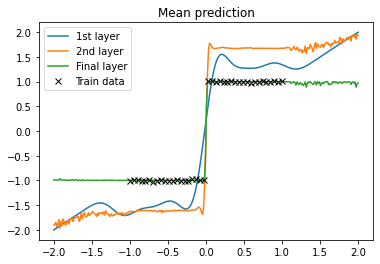

In [11]:
for i in range(3):
    plt.plot(Xs,np.mean(layers_means[i],axis=0))
plt.plot(X_train,Y_train,'kx')
plt.legend(['1st layer','2nd layer','Final layer','Train data'])
plt.title("Mean prediction")
plt.show()

**Plotting the (mean of) variances on the same axis:**

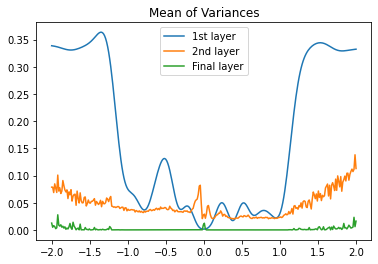

In [12]:
for i in range(3):
    plt.plot(Xs,np.mean(layers_variances[i],axis=0))
plt.legend(['1st layer','2nd layer','Final layer','Train data'])
plt.title("Mean of Variances")
plt.show()

**Plotting each layer separately, with uncertainties:**

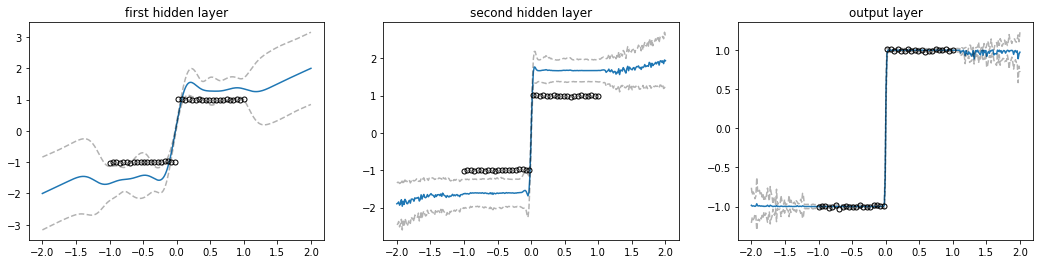

In [13]:
plt.figure(figsize=[18,4])
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(Xs,np.mean(layers_means[i],axis=0))
    plt.plot(Xs,np.mean(layers_means[i],axis=0) + 2*np.sqrt(np.mean(layers_variances[i],axis=0)),'k--',alpha=.3)
    plt.plot(Xs,np.mean(layers_means[i],axis=0) - 2*np.sqrt(np.mean(layers_variances[i],axis=0)),'k--',alpha=.3)
    plt.plot(X_train,Y_train,'ko',markersize=5,fillstyle='none')
    plt.title("{} layer".format(['first hidden','second hidden','output'][i]))


**Comments:**

**In short, the first hidden layer is basically trying to implement a step sunction with a standard Gaussian process regression model (not quite, if you think how gradients are backpropagated; the first layer doesn't really care about pointwise accuracy or scale, just the overall shape of the response). The second layer is trying to get the shape right. The response shows nicely how there are (effectively, comparing to initial inputs) multiple length scales. Uncertainty is also somewhat reduced in the second layer. Finally, the third/output layer is scaling the reponse, and reducing uncertainty.**

--------------------------------------------------------------------------------------------------------------------------------------------
**(Additional pondering) Since the outputs are directly accounted for in the loss, it is perhaps useful to try and reason about the inference chain backwards (in the direction gradients are [back-]propagated). Looking h2 (2nd hidden layer) as it's inputs, the output layer 'sees' already a close to correct form (I am starting at the end of training, and the model is ~fitted). As the loss is/was evaluated pointwise, the output layer is trying to get the response to scaled to match the data, with as little variance.**

**The 2nd hidden layer (h2) 'sees' h1 as it's input but with distorted shape and much uncertainty. So, the second layer tries to match the step transition as accurately as possible - a side note; it is apparently a property of deepGP's, that unlike standard GP's whose outputs are jointly distributed with their *derivatives*, deepGP's derivatives have thick tails (this seems reasonable as already the 2nd layer get's the sharp step correct).**

**As mentioned, the first hidden layer is trying to fit a standard Gaussian process to the step, however, it doesn't care about pointwise accuracy.**

# Part 3: Model inference

**Task 3**: Pick some small data set (or a subset of a big data set). Study a GP model of your own choosing, where the latent values can't be integrated out analytically. 

Examples (See Lecture 9):
- normal(mu,exp(eta)), mu ~ GP, eta ~ GP
  e.g. https://avehtari.github.io/casestudies/Motorcycle/motorcycle.html
- increasing magnitude model
  e.g. https://avehtari.github.io/casestudies/Birthdays/birthdays.html
- non-normal observation model, like Bernoulli, Poisson or negative-binomial
  e.g. http://avehtari.github.io/BDA_R_demos/demos_rstan/trafficdeaths.html

You may use any software you like (Stan, gpflow, gpytorch), and you may use full MCMC or
integrate over latent values using Laplace, EP or VI.

**Write a short report**:
1. describe your model and approach
2. what are optimized parameters vs. posterior of parameters
3. show predictive distribution with optimization vs. posterior predictive

For those familiar with GPflow, see
https://gpflow.readthedocs.io/en/develop/notebooks/advanced/mcmc.html#Example-3:-Fully-Bayesian-inference-for-generalized-GP-models-with-HMC

For those familiar with PyMC3, see
https://docs.pymc.io/notebooks/GP-Latent.html

**Hint**:
- Check the Lecture 9 video
- Studying the motorcycle casestudy is a good starting point
- If you have questions, check the course Slack channel https://join.slack.com/t/gp2021e4075/shared_invite/zt-l0x4rfc5-go1vZngUsvq9ix9wdMQAIQ

## Data Initialization

The data used in this report is generated here. A small dataset has both linear and non-linear structure, and a small number of outliers.  

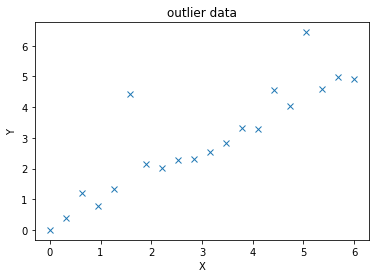

In [7]:
f64 = gpflow.utilities.to_default_float

np.random.seed(14)
X = np.linspace(0, 6, 20)
Y = np.random.exponential(np.sin(X) ** 2) + .8*X + 1e-6

plt.figure()
plt.plot(X, Y, "x")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("outlier data")
plt.show()

data = (X[:, None], Y[:, None])
Xtest=np.linspace(0,7)[:,None]

## Model

The model has a Matern32 kernel, linear mean-function (A,b) to cover the trend, and Student's t observation model (with fixed df) for robustness to outliers. The data could probably be fitted with a simpler approach but it is still interesting to see how the full Bayesian approach can handle possibly overparameterized model, compared to optimization.

$$
A\sim \mathcal{N}(0,1) \\
b\sim \mathcal{N}(0,1) \\
\rho\sim InvGamma(3,1) \\
\alpha\sim Normal_+(1) \\
\mu(x) = Ax + b\\
\sigma\sim Normal_+(1) \\
f\sim GP(\mu(x),K(x\mid \alpha, \rho)) \\
Y \sim StudentT(loc=f, \sigma,\nu=3)
$$

**Defining the gpflow model:**

In [15]:
kernel = gpflow.kernels.Matern32()
mean_function = gpflow.mean_functions.Linear(1.0,0.0)
likelihood = gpflow.likelihoods.StudentT()
model = gpflow.models.GPMC(data, kernel, likelihood, mean_function)

**Setting priors:**

In [16]:
model.kernel.lengthscales.prior = tfd.InverseGamma(f64(3.0), f64(1.0))
model.kernel.variance.prior = tfd.HalfNormal(f64(1.0))

model.mean_function.A.prior  = tfd.Normal(f64(0.0), f64(1.0))
model.mean_function.b.prior = tfd.Normal(f64(0.0), f64(1.0))

model.likelihood.scale.prior = tfd.HalfNormal(f64(1.))

gpflow.utilities.print_summary(model)

╒══════════════════════════╤═══════════╤═════════════╤══════════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                     │ class     │ transform   │ prior        │ trainable   │ shape   │ dtype   │ value   │
╞══════════════════════════╪═══════════╪═════════════╪══════════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPMC.mean_function.A     │ Parameter │ Identity    │ Normal       │ True        │ (1, 1)  │ float64 │ [[1.]]  │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPMC.mean_function.b     │ Parameter │ Identity    │ Normal       │ True        │ ()      │ float64 │ 0.0     │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPMC.kernel.variance     │ Parameter │ Softplus    │ HalfNormal   │ True        │ ()      │ float64 │ 1.0     │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────

**NOTE:**
GPMC samples parameters in an unconstrained space using standard Gaussian. The samples are transformed to constraned space using simple Linear algebra, e.g.;

$$
v\sim \mathcal{N}(\mathbf{0},\mathbf{I}) \\
f = m + Lv \\
$$

where the m and L (Cholesky) hold the model parameters.

**HMC initialization, burn-in 2000, 6000 samples:**

In [17]:
num_burnin_steps = ci_niter(2000)
num_samples = ci_niter(6000)

#this helps with analyzing the result in unconstrained param space
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)

**HMC sampling:**

In [18]:
@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )


samples, _ = run_chain_fn()


parameter_samples = hmc_helper.convert_to_constrained_values(samples)
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

**Traces:**


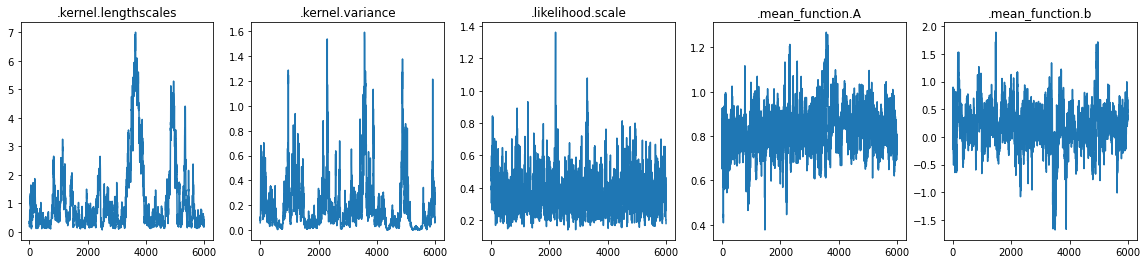

In [19]:
parameter_samples = hmc_helper.convert_to_constrained_values(samples)
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)}

plt.figure(figsize=[20,4])
for i in range(1,4):
    plt.subplot(1,5,i)
    plt.plot(parameter_samples[i])
    plt.title(param_to_name[model.parameters[i]])

plt.subplot(1,5,4)
plt.plot(parameter_samples[4][:,-1])
plt.title(param_to_name[model.parameters[4]])

plt.subplot(1,5,5)
plt.plot(parameter_samples[5])
plt.title(param_to_name[model.parameters[5]])
plt.show()

**NOTE:**
The chain is not fully converging for $\alpha$,$\rho$. However, gpflow doesn't offer the option to run multiple chains in parallel, and manually parsing multiple runs together is a non-trivial task (serially running multiple long chains is somewhat time consuming, and perhaps not meaningfull for demonstration purposes). Since the model still provides reasonable results, I am hoping this will suffice. In the spirit of demonstrating the benefits of sampling, this can be viewed as result after minimal tuning, which should nevertheless outperform point estimate/optimization.  

*Eventhough it was not separately mentioned/asked for, the convergence analysis should be a standard/must part of mcmc. However, in this (demonstrative) context I hope this simple traceplot suffices - I am also aware of the subtelties involved, and only due to time contraints will ignore them here. The model can be independently evaluated/judged, after all, regardless of the robustness of sampling.*





**Posterior of latents (predicting):**

In [20]:
f_samples = []

for i in range(num_samples):
    # convert unconstrained variables to constrained 
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(Xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

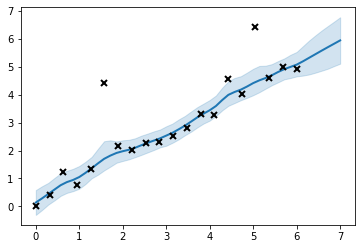

In [21]:
mean=np.mean(f_samples, 0).flatten()
(line,) = plt.plot(Xtest, mean, lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(f_samples, 5, axis=0).flatten(),
    np.percentile(f_samples, 95, axis=0).flatten(),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, Y, "kx", mew=2)

**Posterior predictions (latents through the likelihood/obs.model):**

In [22]:
y_pred=model.predict_y(Xtest)
mean=y_pred[0][:,0]
sd=np.sqrt(y_pred[1]).flatten()#[:,0]

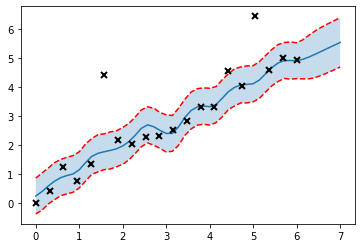

In [23]:
plt.plot(Xtest, mean, label='Mean')
plt.plot(Xtest, mean + 2*sd, 'r',linestyle='--')
plt.plot(Xtest, mean - 2*sd, 'r',linestyle='--')
plt.fill_between(Xtest.ravel(), mean - 2*sd, mean + 2*sd, alpha=0.25, label='Confidence')
plt.plot(X, Y, "kx", mew=2)

The model is able to fit the data relatively well, despite the outliers. With some tuning of the priors, this could be probably improved (the prior for lengthscales could possibly have more mass for higher values - this should make the model slightly more stiff; now the model is not far from overfitting). 

**Parameter samples (constrained and unconstrained space):**

(The function is borrowed, and modified, from gpflow MCMC examples)

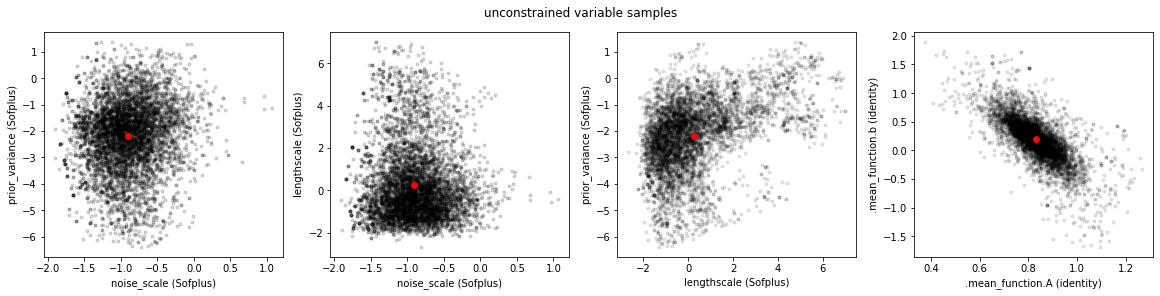

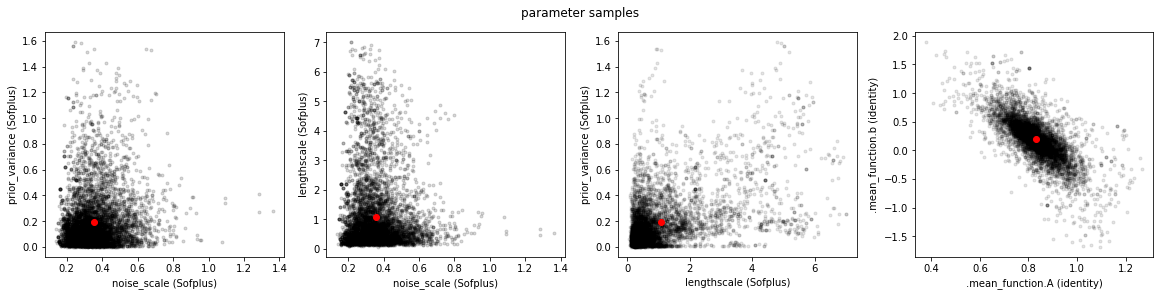

In [24]:
def plot_joint_marginals(samples, parameters, y_axis_label):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.scale"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    axs[0].plot(
        np.mean(samples[name_to_index[".likelihood.scale"]]),
        np.mean(samples[name_to_index[".kernel.variance"]]),
        "ro",
    )
    axs[0].set_xlabel("noise_scale (Sofplus)")
    axs[0].set_ylabel("prior_variance (Sofplus)")

    axs[1].plot(
        samples[name_to_index[".likelihood.scale"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    axs[1].plot(
        np.mean(samples[name_to_index[".likelihood.scale"]]),
        np.mean(samples[name_to_index[".kernel.lengthscales"]]),
        "or",
    )

    axs[1].set_xlabel("noise_scale (Sofplus)")
    axs[1].set_ylabel("lengthscale (Sofplus)")

    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    axs[2].plot(
        np.mean(samples[name_to_index[".kernel.lengthscales"]]),
        np.mean(samples[name_to_index[".kernel.variance"]]),
        "ro",
    )

    axs[2].set_xlabel("lengthscale (Sofplus)")
    axs[2].set_ylabel("prior_variance (Sofplus)")
    #f.suptitle(y_axis_label)
    #plt.show()

    axs[3].plot(
        samples[name_to_index[".mean_function.A"]][:,-1],
        samples[name_to_index[".mean_function.b"]],
        "k.",
        alpha=0.1,
    )
    axs[3].plot(
        np.mean(samples[name_to_index[".mean_function.A"]][:,-1]),
        np.mean(samples[name_to_index[".mean_function.b"]]),
        "ro",
    )
    axs[3].set_xlabel(".mean_function.A (identity)")
    axs[3].set_ylabel(".mean_function.b (identity)")
    f.suptitle(y_axis_label)
    plt.show()


plot_joint_marginals(samples, model.trainable_parameters, "unconstrained variable samples")
plot_joint_marginals(parameter_samples, model.trainable_parameters, "parameter samples")

We can see the spread in lengthscales and variance (which was seen in the traceplots already). Having played with the model, the lengthscale tends to find another mode around 5-6, which is the reason I gave it a more peaked prior. The behaviour seems reasonable, and presumably reflects the fact that the (small) dataset could probably be fitted with a simple linear model: Given wide enough lenghtscales prior, the sampling explores the "stiffer model" as well.

**Marginals of samples, and posterior modes:**

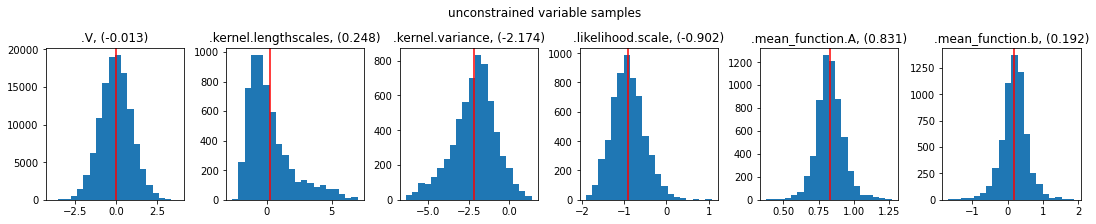

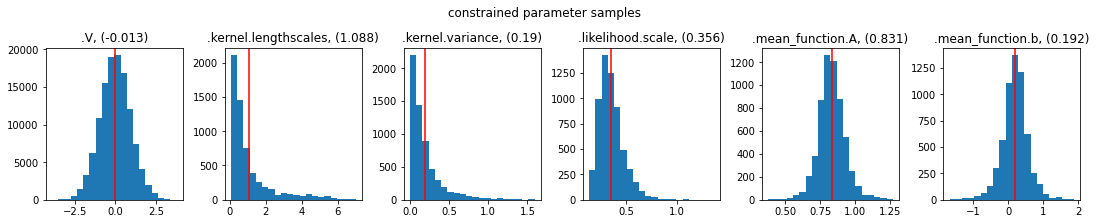

In [25]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        spot=np.mean(val)
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.axvline(x=spot,color='r')
        ax.set_title("{var:}, ({val:})".format(var=param_to_name[param],val=np.round(spot,3)))
    fig.suptitle(y_axis_label)
    plt.show()

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, model.trainable_parameters, "constrained parameter samples")

Using fairly restrictive priors for the troublesome $\alpha,\rho$, the marginals look good.

## Optimized parameters:

Same model, this time using optimizer.

In [26]:
np.random.seed(14)
kernel_opt = gpflow.kernels.Matern32()#lengthscales=model.kernel.lengthscales)
mean_function_opt = gpflow.mean_functions.Linear()#model.mean_function.A,model.mean_function.b)
likelihood_opt = gpflow.likelihoods.StudentT()#model.likelihood.scale)
model_opt = gpflow.models.GPMC(data, kernel_opt, likelihood_opt, mean_function_opt)

In [27]:
model_opt.kernel.lengthscales.prior = tfd.InverseGamma(f64(3.0), f64(1.0))
model_opt.kernel.variance.prior = tfd.HalfNormal(f64(1.0))
model_opt.mean_function.A.prior  = tfd.Normal(f64(0.0), f64(1.0))
model_opt.mean_function.b.prior = tfd.Normal(f64(0.0), f64(1.0))
model_opt.likelihood.scale.prior = tfd.HalfNormal(f64(1.))

In [28]:
gpflow.utilities.print_summary(model_opt)

╒══════════════════════════╤═══════════╤═════════════╤══════════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                     │ class     │ transform   │ prior        │ trainable   │ shape   │ dtype   │ value   │
╞══════════════════════════╪═══════════╪═════════════╪══════════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPMC.mean_function.A     │ Parameter │ Identity    │ Normal       │ True        │ (1, 1)  │ float64 │ [[1.]]  │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPMC.mean_function.b     │ Parameter │ Identity    │ Normal       │ True        │ (1,)    │ float64 │ [0.]    │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPMC.kernel.variance     │ Parameter │ Softplus    │ HalfNormal   │ True        │ ()      │ float64 │ 1.0     │
├──────────────────────────┼───────────┼─────────────┼──────────────┼─────────────┼─────

In [29]:
optimizer = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = optimizer.minimize(
    model_opt.training_loss, model_opt.trainable_variables, options=dict(maxiter=maxiter)
)
# We can now start HMC near maximum a posteriori (MAP)

**The optimized model:**

In [30]:
model_opt

name,class,transform,prior,trainable,shape,dtype,value
GPMC.mean_function.A,Parameter,Identity,Normal,True,"(1, 1)",float64,[[0.84136451]]
GPMC.mean_function.b,Parameter,Identity,Normal,True,"(1,)",float64,[0.19817632]
GPMC.kernel.variance,Parameter,Softplus,HalfNormal,True,(),float64,0.20942513033889731
GPMC.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.10352756889959526
GPMC.likelihood.scale,Parameter,Softplus,HalfNormal,True,(),float64,1.1207179139462044e-06
GPMC.V,Parameter,Identity,Normal,True,"(20, 1)",float64,[[-0.43304607...


**posterior of latents (predicting):**

In [31]:
Xtest=np.linspace(0,7)[:,None]
f_samp_opt = model_opt.predict_f_samples(Xtest,100)[:, :, 0]

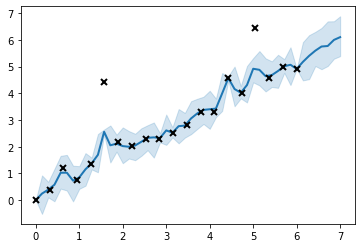

In [32]:
(line,) = plt.plot(Xtest, np.mean(f_samp_opt, 0), lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(f_samp_opt, 5, axis=0),
    np.percentile(f_samp_opt, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, Y, "kx", mew=2)
#plt.ylim(-2, 4)

**Posterior predictions (latents through the likelihood/obs.model):**

In [33]:
y_pred_opt = model_opt.predict_y(Xtest)
mean_opt = y_pred_opt[0][:,0]
sd_opt = np.sqrt(y_pred_opt[1])[:,0]

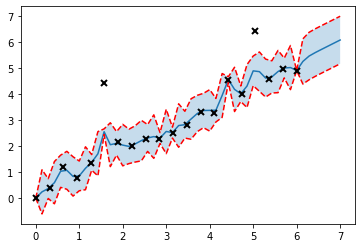

In [34]:
plt.plot(Xtest, mean_opt, label='Mean')
plt.plot(Xtest, mean_opt + 2*sd_opt, 'r',linestyle='--')
plt.plot(Xtest, mean_opt - 2*sd_opt, 'r',linestyle='--')
plt.fill_between(Xtest.ravel(), mean_opt - 2*sd_opt, mean_opt + 2*sd_opt, alpha=0.25, label='Confidence')
plt.plot(X, Y, "kx", mew=2)
#plt.ylim(-2, 4)

**Optimization is consistently finding the linear trend, but having way too small lengthscales and noise. The optimized model is clearly overfitting.**

**Comparing the point estimates (red dots) against the full sampling (the previous model):**

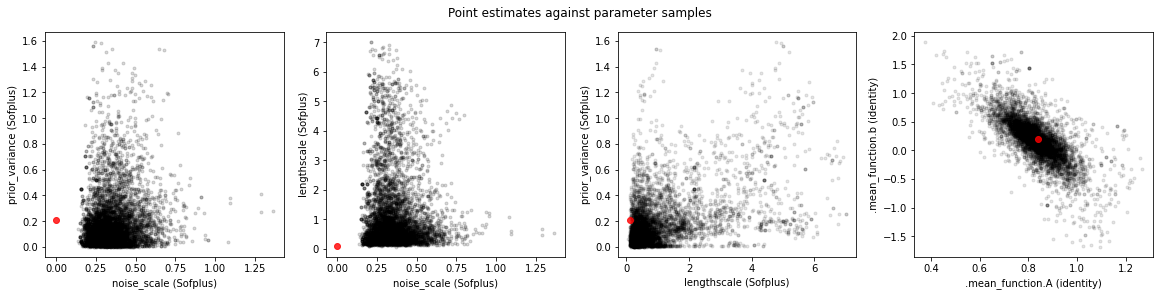

In [39]:
def plot_joint_marginals_2(samples, parameters, y_axis_label, opt_params=None):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.scale"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    if opt_params is not None:
        axs[0].plot(opt_params[name_to_index[".likelihood.scale"]],
            opt_params[name_to_index[".kernel.variance"]],
            "ro",
            alpha=0.8)
    axs[0].set_xlabel("noise_scale (Sofplus)")
    axs[0].set_ylabel("prior_variance (Sofplus)")
########
    axs[1].plot(
        samples[name_to_index[".likelihood.scale"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    if opt_params is not None:
        axs[1].plot(opt_params[name_to_index[".likelihood.scale"]],
            opt_params[name_to_index[".kernel.lengthscales"]],
            "ro",
            alpha=0.8)
    axs[1].set_xlabel("noise_scale (Sofplus)")
    axs[1].set_ylabel("lengthscale (Sofplus)")
##############
    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    if opt_params is not None:
        axs[2].plot(opt_params[name_to_index[".kernel.lengthscales"]],
            opt_params[name_to_index[".kernel.variance"]],
            "ro",
            alpha=0.8)
    axs[2].set_xlabel("lengthscale (Sofplus)")
    axs[2].set_ylabel("prior_variance (Sofplus)")
#################
    axs[3].plot(
        samples[name_to_index[".mean_function.A"]][:,-1],
        samples[name_to_index[".mean_function.b"]],
        "k.",
        alpha=0.1,
    )
    if opt_params is not None:
        axs[3].plot(opt_params[name_to_index[".mean_function.A"]].numpy(),#[:,-1],
            opt_params[name_to_index[".mean_function.b"]].numpy(),
            "ro",
            alpha=0.8)
    axs[3].set_xlabel(".mean_function.A (identity)")
    axs[3].set_ylabel(".mean_function.b (identity)")
    f.suptitle(y_axis_label)
    plt.show()
    
plot_joint_marginals_2(parameter_samples, model.trainable_parameters, "Point estimates against parameter samples",model_opt.parameters)

**The linear mean function is found, and the prior variance looks similar as well. But both lengthscales and noise are severily underestimated.**

(just to show that the parameters are on the constrained space, and there is no mistake in the code...:)

In [36]:
model_opt.kernel.lengthscales.prior_on

<PriorOn.CONSTRAINED: 'constrained'>

In [37]:
model_opt

name,class,transform,prior,trainable,shape,dtype,value
GPMC.mean_function.A,Parameter,Identity,Normal,True,"(1, 1)",float64,[[0.84136451]]
GPMC.mean_function.b,Parameter,Identity,Normal,True,"(1,)",float64,[0.19817632]
GPMC.kernel.variance,Parameter,Softplus,HalfNormal,True,(),float64,0.20942513033889731
GPMC.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.10352756889959526
GPMC.likelihood.scale,Parameter,Softplus,HalfNormal,True,(),float64,1.1207179139462044e-06
GPMC.V,Parameter,Identity,Normal,True,"(20, 1)",float64,[[-0.43304607...


**Final words:**

Even with this relatively ad hoc model, sampling is the more robust approach. Averaging over the samples integrates the different sources of uncertainty into the predictions (ensemble effect/model averaging). 

# END